Import the necessary packages

In [ ]:
import math
#%matplotlib qt5
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
# Display all floats rounded off to 1 decimal place
pd.options.display.float_format = '{:,.1f}'.format
# Plot inline in Jupyter notebook
# Settings throughout the notebook
sns.set()
# Width = 16, Height = 6
DIMS=(16, 6)
import os

# multiprocessing libraries
from itertools import repeat
from multiprocessing import Pool, Manager
from tqdm import tqdm
import cProfile
import random
import re    
import functools
import json

# for travelling salesman
import string

Define the optimization test function here - Bukin Function N.6

https://www.sfu.ca/~ssurjano/bukin6.html

In order to apply the simulated annealing method to a specific problem, one must specify the following parameters: the boundary, the energy (goal) function E(), the candidate generator procedure neighbour(), the acceptance probability function P(), and the annealing schedule temperature() AND initial temperature <init temp>. 

In [ ]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# note if you want to change the function, remember to change the boundaries at which the function is evaluated!


class Annealer(object):
    '''
    Pass the max steps you want to take to the annealer function
    '''

    def __init__(
        self,
        maxsteps=500,
        multiplier=1,
        control_t=1,
        acceptrate=0.5,
        explore=30,
        lams=1,
        i1=np.arange(-15.0, 10., 0.01),
        i2=np.arange(-10., 10.02, 0.01),
        ):
        '''
        inputs:   
        maxsteps - total number of temperature steps to anneal for (default = 500)
        multiplier - eometric multiplier for annealing schedule (default = 1 OFF)
        control_t - whether you want to turn on or off the geometric cooling schedule (default = 1 OFF)
        acceptrate - generic lam's acceptance rate (default = 0.5)
        explore - number of steps to explore at every iteration (default = 30 steps per iteration)
        lams - whether to turn on or off lam's annealing schedule (default = 1 OFF)
        
        Initialize parameters
        
        output: none
        '''

        self.Tmax = maxsteps
        self.threshold = multiplier
        self.interval = list()
        self.over_count = 0

        # self.states = {"x":list(), "y":list()}

        self.acceptrate = acceptrate
        self.control = control_t
        self.exploration_space = explore
        self.trig_lams = lams
        self.real_answer = -1.8013
        self.lams = dict()
        self.accepts = dict()
        self.i1 = i1
        self.i2 = i2

    def get_range(self):
        '''
        function to get range from the user
        '''
        i1 = input('Please input desired x1 range in the form x1,y1: \n'
                   )
        i2 = input('Please input desired x1 range in the form x1,y1: \n'
                   )

        special_chars = r'[`\=~!@#$%^&*()_+\[\]{};\'\\:"|<,/<>?]'

        (i1, i2) = (re.split(special_chars, i1),
                    re.split(special_chars, i2))
        (i1, i2) = ([np.float(i) for i in i1], [np.float(i) for i in
                    i1])
        i1 = np.arange(min(i1), max(i1), 0.01)
        i2 = np.arange(min(i2), max(i2), 0.01)

        return (i1, i2)

    def random_start(self):
        """ 
        input: none
        
        Randomly choose a random starting point within the boundary
        
        output: a pair of starting point coordinates (x1, x2)
        """

        self.interval.append([random.uniform(self.i1[0], self.i1[-1]),
                             random.uniform(self.i2[0], self.i2[-1])])

        return self.interval


    def f(self, x):
        '''
        input: x (a 2D array)
        
        Function that evaluates the cost of a given x1, x2
        
        output: single cost
        '''

        x1 = x[0]
        x2 = x[1]
    
    # function 1, levy function 
        obj = np.sin(3 * np.pi * x[0]) ** 2 + (x[0] - 1) ** 2 * (1
                + np.sin(3 * np.pi * x[1]) ** 2) + (x[1] - 1) ** 2 * (1
                + np.sin(2 * np.pi * x[1]) ** 2)

        # self.i1 = np.arange(-10.0, 10., 0.01)
        # self.i2 = np.arange(-10.0, 10., 0.01)

        # obj = 100 * np.sqrt(abs(x[1] - 0.01*(-x[0])**2)) + 0.01 * abs(x[0] + 10)
        # self.i1 = np.arange(-15.0, 10., 0.01)
        # self.i2 = np.arange(-15.0, 10., 0.01)

        #obj = - ((np.sin(x[1])* (np.sin((x[1]**2) / (np.pi))**20 )) + (np.sin(x[1])*(np.sin(2*(x[1]**2) / (np.pi))**20 )))
        # self.i1 = np.arange(0, np.pi, 0.01)
        # self.i2 = np.arange(0, np.pi, 0.01)

        return obj


    def random_neighbour(self, x):
        """ 
        input: x (a 2D array)
        
        Move a little bit x1 and x2, from the left or the right and then check whether it's within
        the boundary. (normalized by the min and max) 
        if it's within the boundary, return the new coordinates, otherwise find new ones.
        
        output: (newx, newy)
        """

        # normalized

        deltax = random.uniform(self.i1[0], self.i1[-1])
        deltay = random.uniform(self.i2[0], self.i2[-1])

        newx = x[0] + deltax
        newy = x[1] + deltay

        return [newx, newy]


    def acceptance_probability(
        self,
        cost,
        new_cost,
        temperature,
        ):
        '''
        inputs: old cost, new cost, current temperature
        
        calculate probability of acceptance and return it using the metropolis algorithm
        
        output: probability (0 to 1)
        '''

        return np.exp(-(new_cost - cost) / temperature)


    def restart(self):
        '''
        reinitializes at a random point
        '''

        state = self.random_start()[0]
        cost = self.f(state)
        return (state, cost)


    def anneal(self):
        '''
        inputs: none
        
        function performs annealing and calls random start to kickstart the annealing process. iteratively
        calculates the new cost.
        
        output: final cost, final state (list of x1 and x2), all costs (list of costs at every timestep)
        '''

        best_cost = list()
        current_cost = list()
        deviation = list()
        T_list = list()
    
        acceptrate = self.acceptrate
        (states, costs) = self.restart()
        LamRate = 0

        best_cost.append(costs)

        for temp_step in range(self.Tmax):
            

            fraction = temp_step / float(self.Tmax)

        # T = max((1-self.trig_lams) * max(fraction*(1-self.control), (1 - fraction) * self.control) * self.threshold, (1-fraction)*self.trig_lams)

        # if you want to trigger lam's, self.control == 1

            if self.control == 0 & temp_step > 0:
                T = self.threshold * (1 - fraction)
            else:
                T = 1 - fraction

            T_list.append(T)

            for step in range(self.exploration_space):

                new_cost = costs
                new_state = states

                gen_new_state = self.random_neighbour(new_state)
                gen_new_cost = self.f(gen_new_state)

                if gen_new_cost < new_cost:
                    new_state = self.random_neighbour(states)
                    new_cost = self.f(new_state)

            current_cost.append(new_cost)

            if new_cost < costs or self.acceptance_probability(costs,
                new_cost, T) >= random.uniform(0, 1):
                states, costs = new_state, new_cost

            if self.trig_lams == 1:
                acceptrate = 1 / 500 * (499 * acceptrate + 1)
            else:

                if self.trig_lams == 1:

                    acceptrate = 1 / 500 * (499 * acceptrate)

                    # check conditions

                    if fraction < 0.15:
                        LamRate = 0.44 + 0.56 * 560 ** (-temp_step
                          / (self.Tmax * 0.15))
                    elif fraction < 0.65:
                        LamRate = 0.44
                    else:
                        LamRate = 0.44 * 440 ** ((-temp_step
                          / self.Tmax - 0.65) / 0.35)


                    if LamRate < acceptrate:
                        T *= 0.99
                    else:
                        T *= 1 / 0.999

            
            deviation.append(abs(costs - self.real_answer))

            if best_cost[-1] > costs:
                best_cost.append(costs)
            else:
                best_cost.append(best_cost[-1])

            if self.trig_lams == 1:
                if temp_step not in list(self.lams.keys()):
                    self.lams[temp_step] = list()
                if temp_step not in list(self.accepts.keys()):
                    self.accepts[temp_step] = list()
                self.lams[temp_step].append(LamRate)
                self.accepts[temp_step].append(acceptrate)


        return (
            current_cost,
            best_cost[1:],
            deviation,
            self.accepts,
            self.lams,
            T_list,
            )


# Test with 10000 steps and profile the run times

In [ ]:
#@title
cost = Annealer(1000)
cProfile.run('cost.anneal()')
#cost

# Example 1: Using a Linear Ramp to adjust the Annealing Schedule (1-ti/Tmax)
To use the linear ramp, you only need to:
### adjust the max number of steps to your preference

In [ ]:
tries1 = {"run":list(), "temp":list(), "current_cost":list(), "best_cost":list(), "deviations":list()}

for i in range(0, 100, 1):
    a = Annealer(maxsteps = 5000, i1 = np.arange(-10.0, 10., 0.01), i2 = np.arange(-10.0, 10., 0.01))
    current_cost, best_cost, deviations, accepts, lams, T = a.anneal()
    cost_keys = len(list(current_cost))
    for k in range(cost_keys):
        tries1['run'].append(i)
        tries1['temp'].append(T[k])
        tries1['current_cost'].append(current_cost[k]) 
        tries1['best_cost'].append(best_cost[k])
        tries1['deviations'].append(deviations[k])

''' converts the dictionary into a pandas dataframe for easy data manipulation'''
df_case1 = pd.DataFrame.from_dict(tries1)
df_case1.head(20)
df_case1_group_mean = df_case1.groupby(['temp']).mean().reset_index()
df_case1_group_mean.to_csv("case1_func3.csv")



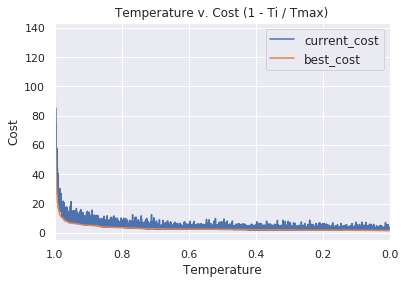

In [ ]:
fig, ax1 = plt.subplots(1, 1)

plt.xlabel("Temperature")
plt.ylabel("Cost", fontsize=12)

        #Add the legend
plt.title("Temperature v. Cost (1 - Ti / Tmax)")
plt.xlim(1.0, 0)
#plt.ylim(0,100)
plt.plot(df_case1_group_mean['temp'].tolist(), df_case1_group_mean['current_cost'].tolist(), label='current_cost')
plt.plot(df_case1_group_mean['temp'].tolist(), df_case1_group_mean['best_cost'].tolist(), label='best_cost')
plt.legend(fontsize=12)
plt.savefig('case_1_costs.png')
    


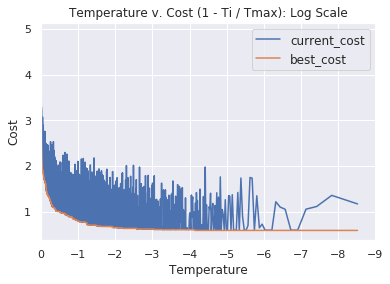

In [ ]:
fig, ax1 = plt.subplots(1, 1)
plt.xlabel("Temperature")
plt.ylabel("Cost", fontsize=12)

#Add the legend
plt.title("Temperature v. Cost (1 - Ti / Tmax): Log Scale")
plt.xlim(0,-9)

plt.plot(df_case1_group_mean['temp'].apply(np.log).tolist(), df_case1_group_mean['current_cost'].apply(np.log).tolist(), label='current_cost')
plt.plot(df_case1_group_mean['temp'].apply(np.log).tolist(), df_case1_group_mean['best_cost'].apply(np.log).tolist(), label='best_cost')
plt.legend(fontsize=12)
plt.savefig('case_1_costs_log.png')


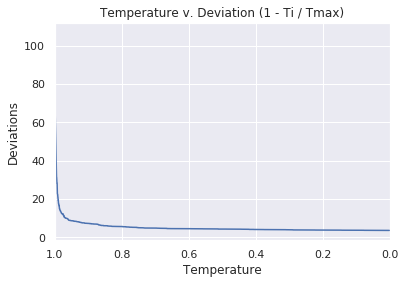

In [ ]:
fig, ax1 = plt.subplots(1, 1)
plt.xlabel("Temperature")
plt.ylabel("Deviations", fontsize=12)

#Add the legend
plt.title("Temperature v. Deviation (1 - Ti / Tmax)")
plt.xlim(1.0, 0)
plt.plot(df_case1_group_mean['temp'].tolist(), df_case1_group_mean['deviations'].tolist(), label='mean')
plt.savefig('case_1_deviations.png')



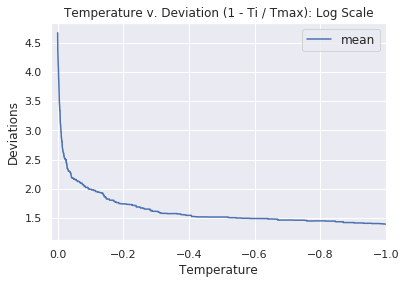

In [ ]:
fig, ax1 = plt.subplots(1, 1)
#print(current_df)
plt.xlabel("Temperature")
plt.ylabel("Deviations", fontsize=12)

    #Add the legend
plt.title("Temperature v. Deviation (1 - Ti / Tmax): Log Scale")
plt.xlim(0.02, -1)

plt.plot(df_case1_group_mean['temp'].apply(np.log).tolist(), df_case1_group_mean['deviations'].apply(np.log).tolist(), label='mean')
plt.savefig('case_1_deviations_log.png')
plt.legend(fontsize=12)


# Example 2: Using a Geometric factor to adjust the annealing schedule (ti * g)
To use the geometric ramp, you need to pass 3 parameters: 
### adjust the max number of steps to your preference, 
### the probability j (you can adjust using geoms) - note it takes in a decimal, 
### and control_t = 0

In [ ]:
tries2 = {"probability":list(), "run":list(), "temp":list(), "current_cost":list(), "best_cost":list(), "deviations":list()}
geoms = [0.99, 0.98, 0.9, 0.8, 0.7, 0.6]

for j in geoms:
    print(j)
    for i in range(0, 100, 1):
        current = dict()
        a = Annealer(maxsteps = 5000, multiplier = j, control_t = 0, i1 = np.arange(-10.0, 10., 0.01), i2 = np.arange(-10.0, 10., 0.01))
        current_cost, best_cost, deviations, accepts, lams, T = a.anneal()
        cost_keys = len(list(current_cost))
        for k in range(cost_keys):
            tries2['probability'].append(j)
            tries2['run'].append(i)
            tries2['temp'].append(T[k])
            tries2['current_cost'].append(current_cost[k]) 
            tries2['best_cost'].append(best_cost[k])
            tries2['deviations'].append(deviations[k])
            

            
df_case2 = pd.DataFrame.from_dict(tries2)
df_case2_group_mean = df_case2.groupby(['temp', 'probability']).mean().reset_index()
df_case2_group_mean.to_csv('case2_func3.csv')

0.99
0.98
0.9
0.8
0.7
0.6


## Example of Obtaining the Deviations of Varying geometric rates (plotting code)

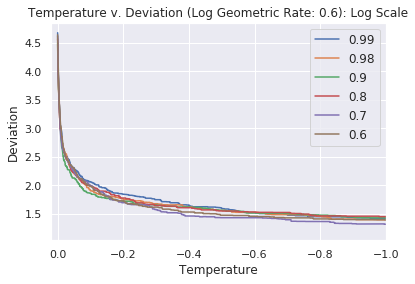

In [ ]:
for i in geoms:
    df_case2_group_mean_use = df_case2_group_mean[df_case2_group_mean['probability']==i]
    #dataframes = [df_case2_group_mean, df_case2_group_max, df_case2_group_min, df_case2_group_std]
    #dataframe_name = ['mean', 'max', 'min', 'std']

    #print(current_df)
    #fig, ax1 = plt.subplots(1, 1)
    plt.xlabel("Temperature")
    plt.ylabel("Deviation", fontsize=12)

        #Add the legend
    plt.title("Temperature v. Deviation (Log Geometric Rate: {}): Log Scale".format(i))
    plt.xlim(0.02, -1)

    plt.plot(df_case2_group_mean_use['temp'].apply(np.log).tolist(), df_case2_group_mean_use['deviations'].apply(np.log).tolist(), label=i) # need to redefine the names
    plt.legend(fontsize=12)

    plt.savefig('case2_geom_deviation_log.png'.format(i))
    

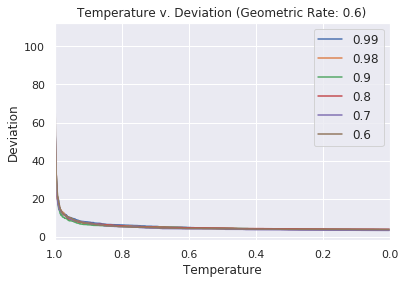

In [ ]:
for i in geoms:
    df_case2_group_mean_use = df_case2_group_mean[df_case2_group_mean['probability']==i]
    #dataframes = [df_case2_group_mean, df_case2_group_max, df_case2_group_min, df_case2_group_std]
    #dataframe_name = ['mean', 'max', 'min', 'std']

    #print(current_df)
    #fig, ax1 = plt.subplots(1, 1)
    plt.xlabel("Temperature")
    plt.ylabel("Deviation", fontsize=12)

        #Add the legend
    plt.title("Temperature v. Deviation (Geometric Rate: {})".format(i))
    plt.xlim(1.0, 0)
#    plt.ylim(0,30)

    plt.plot(df_case2_group_mean_use['temp'].tolist(), df_case2_group_mean_use['deviations'].tolist(), label=i) # need to redefine the names
    plt.legend(fontsize=12)

    plt.savefig('case2_geom_deviation.png'.format(i))
    

## Example of Obtaining the Costs of Varying geometric rates

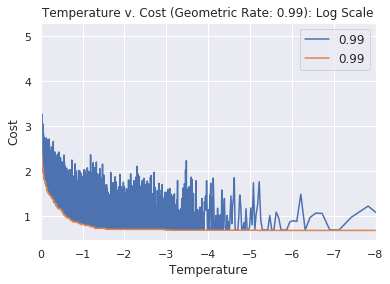

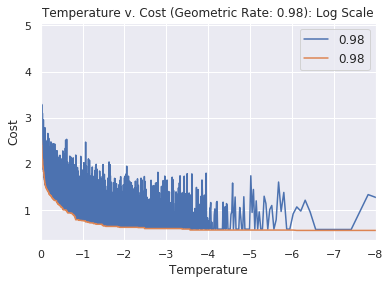

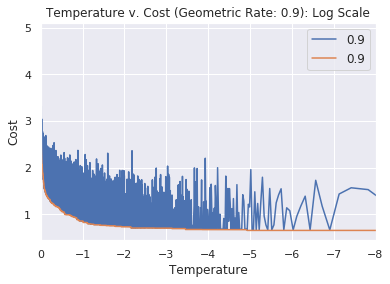

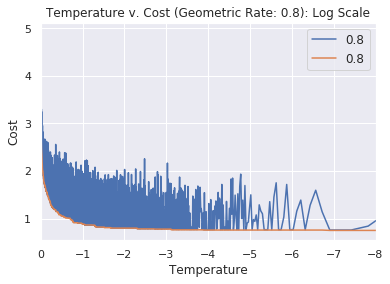

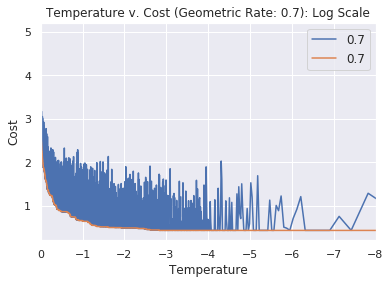

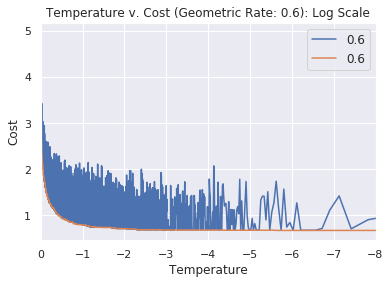

In [ ]:
for i in geoms:
    df_case2_group_mean_use = df_case2_group_mean[df_case2_group_mean['probability']==i]
    #dataframes = [df_case2_group_mean, df_case2_group_max, df_case2_group_min, df_case2_group_std]
    #dataframe_name = ['mean', 'max', 'min', 'std']

    #print(current_df)
    fig, ax1 = plt.subplots(1, 1)
    plt.xlabel("Temperature")
    plt.ylabel("Cost", fontsize=12)

        #Add the legend
    plt.title("Temperature v. Cost (Geometric Rate: {}): Log Scale".format(i))
    
    plt.xlim(0,-8)

    plt.plot(df_case2_group_mean_use['temp'].apply(np.log).tolist(), df_case2_group_mean_use['current_cost'].apply(np.log).tolist(), label=i) # need to redefine the names
    plt.plot(df_case2_group_mean_use['temp'].apply(np.log).tolist(), df_case2_group_mean_use['best_cost'].apply(np.log).tolist(), label=i) # need to redefine the names
    
    plt.legend(fontsize=12)

    plt.savefig('case2_geom_cost_log_{}.png'.format(i))
    

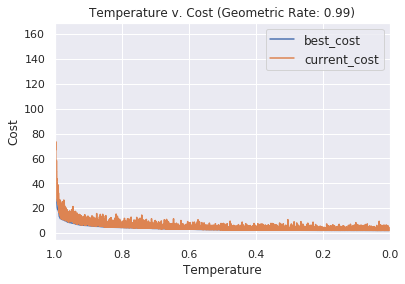

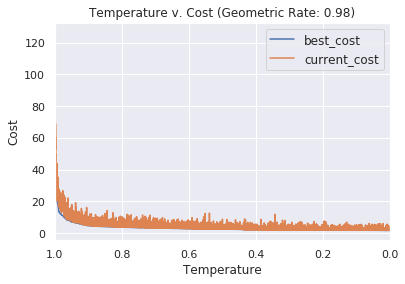

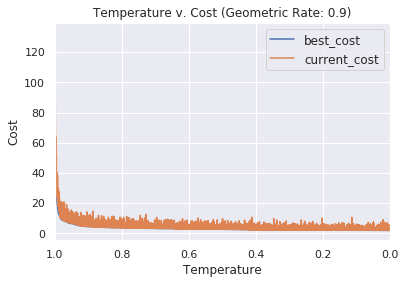

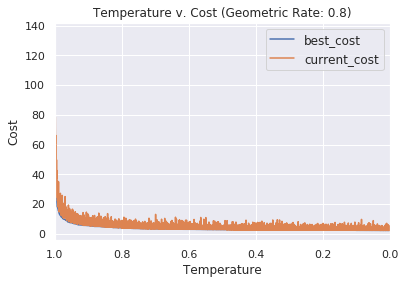

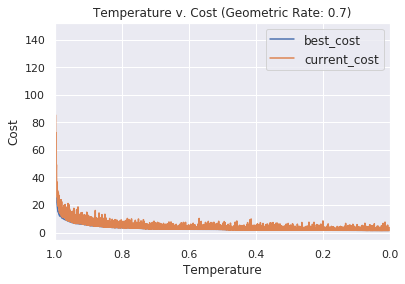

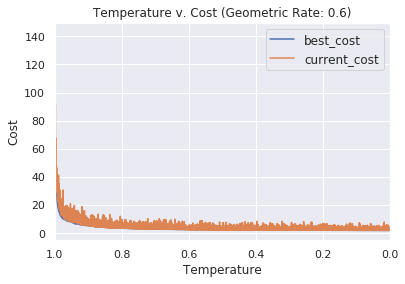

In [ ]:
for i in geoms:
    df_case2_group_mean_use = df_case2_group_mean[df_case2_group_mean['probability']==i]
    fig, ax1 = plt.subplots(1, 1)
    plt.xlabel("Temperature")
    plt.ylabel("Cost", fontsize=12)


    plt.title("Temperature v. Cost (Geometric Rate: {})".format(i))
    plt.xlim(1.0, 0)
#    plt.ylim(0,100)

    plt.plot(df_case2_group_mean_use['temp'].tolist(), df_case2_group_mean_use['best_cost'].tolist(), label='best_cost') # need to redefine the names
    plt.plot(df_case2_group_mean_use['temp'].tolist(), df_case2_group_mean_use['current_cost'].tolist(), label='current_cost') # need to redefine the names

    plt.legend(fontsize=12)

    plt.savefig('case2_geom_cost_{}.png'.format(i))
    

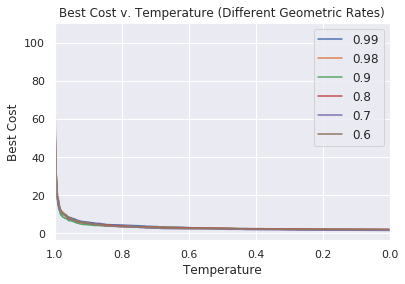

In [ ]:
for i in geoms:
    df_case2_group_mean_use = df_case2_group_mean[df_case2_group_mean['probability']==i]

    #fig, ax1 = plt.subplots(1, 1)
    plt.xlabel("Temperature")
    plt.ylabel("Best Cost", fontsize=12)

    plt.title("Best Cost v. Temperature (Different Geometric Rates)".format(i))
    plt.xlim(1.0, 0)
#    plt.ylim(0,100)

    plt.plot(df_case2_group_mean_use['temp'].tolist(), df_case2_group_mean_use['best_cost'].tolist(), label=i) # need to redefine the names
    plt.legend(fontsize=12)

plt.savefig('case2_geom_best_compiled.png')
    

Calculate the average costs for each number of runs

# Example 3: Lam's Adaptive Learning Rate

## Plotting Lam's with varying accept_rates

In [ ]:
tries3 = {"accept":list(), "run":list(), "temp":list(), "current_cost":list(), "best_cost":list(), "deviations":list()}

acceptrate = [i/10 for i in range(2, 8, 1)]
#acceptrate = [0.5]

for q in acceptrate:
    print(q)
    for i in range(0, 100, 1):
        a = Annealer(5000, 1, acceptrate=q, lams=1, i1 = np.arange(-10.0, 10., 0.01), i2 = np.arange(-10.0, 10., 0.01))
        current_cost, best_cost, deviations, accepts, lams, T = a.anneal()
        cost_keys = len(list(current_cost))
        for k in range(cost_keys):
            tries3['accept'].append(q)
            tries3['run'].append(i)
            tries3['temp'].append(T[k])
            tries3['current_cost'].append(current_cost[k]) 
            tries3['best_cost'].append(best_cost[k])
            tries3['deviations'].append(deviations[k])
            
df_case3 = pd.DataFrame.from_dict(tries3)
df_case3_group_mean = df_case3.groupby(['temp','accept']).mean().reset_index()
df_case3_group_mean.to_csv("case3_func2.csv")


0.5


In [ ]:
for i in acceptrate:
    df_case3_group_mean_use = df_case3_group_mean[df_case3_group_mean['accept']==i]

    #fig, ax1 = plt.subplots(1, 1)
    plt.xlabel("Temperature")
    plt.ylabel("Deviation", fontsize=12)
    plt.title("Temperature v. Deviation (Varying Acceptance Rate)")
    plt.xlim(1.0, 0)
    
    plt.plot(df_case3_group_mean_use['temp'].tolist(), df_case3_group_mean_use['deviations'].tolist(), label='{}'.format(i)) # need to redefine the names
    plt.legend(fontsize=12)
    plt.savefig('case3_lams_deviation_accept_compiled.png'.format(i))
    

In [ ]:
for i in acceptrate:
    df_case3_group_mean_use = df_case3_group_mean[df_case3_group_mean['accept']==i]

    #fig, ax1 = plt.subplots(1, 1)
    plt.xlabel("Temperature")
    plt.ylabel("Deviation", fontsize=12)

    plt.title("Temperature v. Deviation (Varying Acceptance Rate): Log Scale")
    plt.xlim(0.02,-1.0)
    
    plt.plot(df_case3_group_mean_use['temp'].apply(np.log).tolist(), df_case3_group_mean_use['deviations'].apply(np.log).tolist(), label='{}'.format(i)) # need to redefine the names
    plt.legend(fontsize=12)
    plt.savefig('case3_lams_deviation_log_accept_compiled.png'.format(i))
   

In [ ]:
for i in acceptrate:
    df_case3_group_mean_use = df_case3_group_mean[df_case3_group_mean['accept']==i]
    fig, ax1 = plt.subplots(1, 1)
    plt.xlabel("Temperature")
    plt.ylabel("Cost", fontsize=12)
    plt.title("Temperature v. Cost (Acceptance Rate: {})".format(i))
    plt.xlim(1.0, 0)
    #plt.ylim(0, 10)

    plt.plot(df_case3_group_mean_use['temp'].tolist(), df_case3_group_mean_use['current_cost'].tolist(), label='current_cost') # need to redefine the names
    plt.plot(df_case3_group_mean_use['temp'].tolist(), df_case3_group_mean_use['best_cost'].tolist(), label='best_cost') # need to redefine the names
    
    plt.legend(fontsize=12)
    plt.savefig('case3_lams_cost_accept_{}.png'.format(i))
    

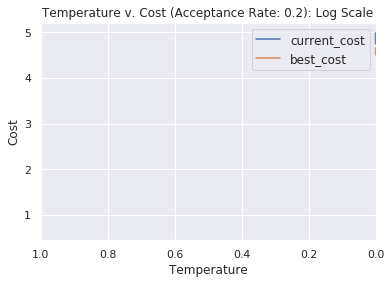

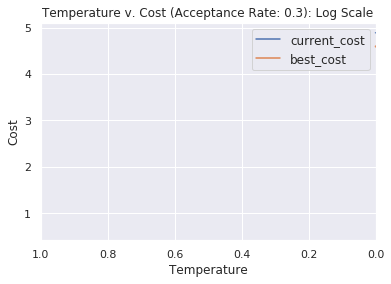

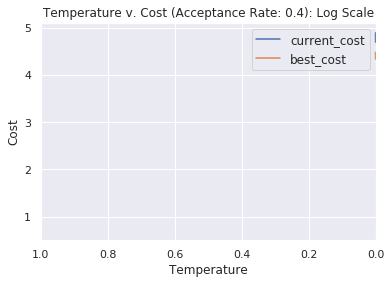

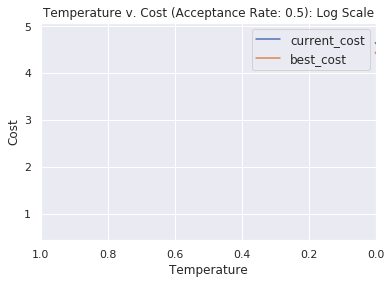

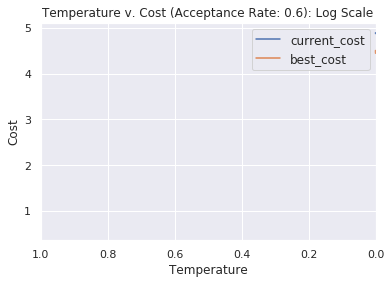

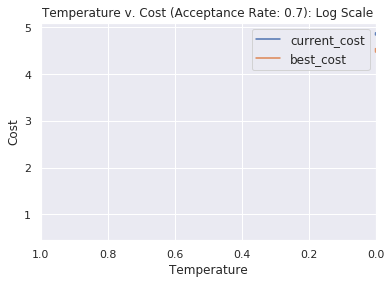

In [ ]:
for i in acceptrate:
    df_case3_group_mean_use = df_case3_group_mean[df_case3_group_mean['accept']==i]
    fig, ax1 = plt.subplots(1, 1)
    plt.xlabel("Temperature")
    plt.ylabel("Cost", fontsize=12)
    plt.title("Temperature v. Cost (Acceptance Rate: {}): Log Scale".format(i))
    plt.xlim(1.0, 0)
    #plt.ylim(0, 10)

    plt.plot(df_case3_group_mean_use['temp'].apply(np.log).tolist(), df_case3_group_mean_use['current_cost'].apply(np.log).tolist(), label='current_cost') # need to redefine the names
    plt.plot(df_case3_group_mean_use['temp'].apply(np.log).tolist(), df_case3_group_mean_use['best_cost'].apply(np.log).tolist(), label='best_cost') # need to redefine the names
    
    plt.legend(fontsize=12)
    plt.savefig('case3_lams_cost_accept_{}.png'.format(i))
    

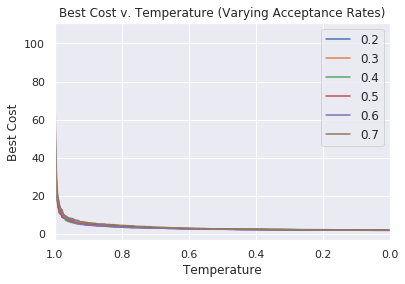

In [ ]:
for i in acceptrate:
    df_case3_group_mean_use = df_case3_group_mean[df_case3_group_mean['accept']==i]
    #fig, ax1 = plt.subplots(1, 1)
    plt.xlabel("Temperature")
    plt.ylabel("Best Cost", fontsize=12)
    colormap = plt.cm.gist_ncar
    plt.title("Best Cost v. Temperature (Varying Acceptance Rates)")
    plt.xlim(1.0, 0)
#    plt.ylim(0,100)

    plt.plot(df_case3_group_mean_use['temp'].tolist(), df_case3_group_mean_use['best_cost'].tolist(), label=i) # need to redefine the names
    plt.legend(fontsize=12)

plt.savefig('case3_geom_best_compiled.png')
    